# Adversarial Search: Playing "Mean" Connect 4


## Instructions

All student names in group: Hojat Jaffary, Dong Liang, Kevin Zheng

I understand that my submission needs to be my own group's work: HJ, DL, KZ

I understand that ChatGPT / Copilot / other AI tools are not allowed: HJ, DL, KZ

Points: 10

Complete this notebook and submit it (save/print as pdf). The notebook needs to be a complete project report with your implementation, documentation including a short discussion of how your implementation works and your design choices, and experimental results (e.g., tables and charts with simulation results) with a short discussion of what they mean. Use the provided notebook cells and insert additional code and markdown cells as needed.

## Introduction

You will implement different versions of agents that play "Mean" Connect 4:

> "Connect 4 is a two-player connection board game, in which the players choose a color and then take turns dropping colored discs into a seven-column, six-row vertically suspended grid. The pieces fall straight down, occupying the lowest available space within the column. The objective of the game is to be the first to form a horizontal, vertical, or diagonal line of four of one's own discs." (see [Connect Four on Wikipedia](https://en.wikipedia.org/wiki/Connect_Four))

> **The mean part:** This game has an additional rule. Every time it is a player's turn, the player can decide to instead of playing a new disk, take a bottom row disk of the opponent and place it back in the top of the same column. All disks above the removed disk will fall down one position and the removed one will be placed on top. Note that a player can only move an _opponent's disc_ that is in the _bottom row_ of the board. **Further, you are not allowed to play a mean move if your opponent just played one.** This ensures the game will end at some point. This also may affect the definition of a state, compared with standard Connect 4.

If a mean move causes both players to win, the game immediately ends and it is a tie, even if one player has more connect-4s than the other one. If a mean move causes one player to win, then the game also ends and the player with the connect-4 is the winner.

Note that normal [Connect-4 has been solved](https://en.wikipedia.org/wiki/Connect_Four#Mathematical_solution)
in 1988. A connect-4 solver with a discussion of how to solve different parts of the problem can be found here: https://connect4.gamesolver.org/en/

## Task 1: Defining the Search Problem [1 point]

Define the components of the search problem associated with this game:

* Initial state
* Actions
* Transition model
* Test for the terminal state
* Utility for terminal states

## Defining Components

### Initial State
--------------------

Initial state of the problem starts with an empty 7 column and 6 row game board. Allowing for the first move to be putting a disk in any of the bottom rows

`initial_state = empty_board(shape=(6,7))`

### Actions
--------------------
The actions a player can make are:

- Placing Disc
    - for any column in columns and `not isFull(column)`
    - 0 <= column < columns
- Mean Move
    - `if prev_mean = False`
    - remove opponents botton disc making the whole column go down one then place disc back on top

### Transition Model
--------------------
Since this problem is in a known environment, the agent can predict the outcome of action as it knows the transition function but each action will have an effect on the outcome of the game. The transition function is an outcome of a certain action performed on the agent and its current state. To go from state A -> B, at state A there must be some action that causes a transition from one state to another.

**Player(1) chooses column i to place disc**
- `open = lowest_open(i)`
- `board[open][i] = 1`

Whatever column chosen, the lowest open row is now filled with players inidcator, A -> B

**Player(1) chooses mean move on column i**
- `removed = board[6][i]`
- `board = mean(i)`
- `open = lowest_open(i)`
- `board[open][i] = removed`

Whatever column chosen with an opponent piece on bottom, piece is removed all rows in that column go down and the removed piece goes to the top

### Test for the terminal state
-------------------
TERMINATING STATES
- If opponent has `[horizontal, vertical, diagonal]` one of which must be 4.
- If player has `[horizontal, vertical, diagonal]` one of which must be 4.
- If mean move causes both players to have connect 4 TIE.

### Utility for terminal states
-----------------
- If a player achieves a connect-4 (horizontal, vertical, or diagonal), they win the game. Therefore, the utility for a terminal state where one player has a connect-4 is +1 for the player who achieved the connect-4 and -1 for the opponent.

- If both players achieve a connect-4 as a result of a mean move, the game ends in a tie. Therefore, the utility for this terminal state is 0 for both players.

- If a player achieves a connect-4 as a result of a mean move, they win the game. Therefore, the utility for this terminal state is +1 for the player who achieved the connect-4 and -1 for the opponent.


How big is the state space? Give an estimate and explain it.

**Initial**
There are 7 columns and 6 rows, resulting into 42 slots. A slot can be either empty, player 1, or player 2. a configuration of 3^42 with out considering a mean move.

**Considering Mean move**
The amount of mean moves that can be done in a game is varying as it depends on how many discs of the opponent is on the bottom so we can set this variable to N. The number of combination of mean moves is 2^N.

The state space is around 3^42 * 2^N where N is a variable that varies depending on the progress of the game

How big is the game tree that minimax search will go through? Give an estimate and explain it.

The game tree that minimax search will go through is very large because the branching factor is large and varying.

The branching factor at each level is the number of columns plus the number of positions where mean moves are possible. (7 + N) is the branching factor, where N is the variable that varies depending on progress of the game.

To estimate of Max depth of the tree with out mean rule is 42. The game tree will be larger than 7^42 which is about 311,973,482,284,542,371,301,330,321,821,976,049.

This is not considering the larger branching factor with the mean rule

## Task 2: Game Environment and Random Agent [3 point]

You can use a numpy character array as the board. Note that the following function can create boards of different sizes.

In [ ]:
import numpy as np

def empty_board(shape=(6, 7)):
    return np.full(shape=shape, fill_value=0)

print(empty_board())

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]


Instead of colors (red and yellow), you can use 1 and -1 to represent the players Max and Min. Make sure that your agent functions all have the from: `agent_type(state, player = 1)`, where board is the current board position and player is the player (1, -1) whose next move it is and who the agent should play.

Visualization code by Randolph Rankin:

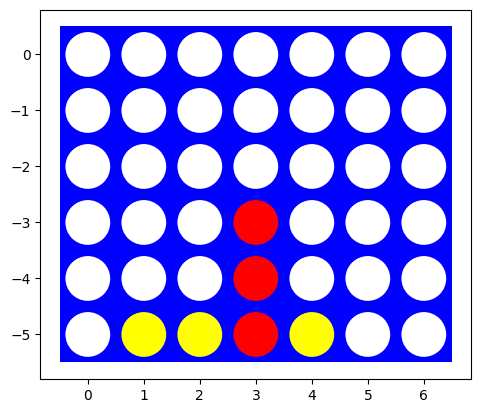

In [ ]:
import matplotlib.pyplot as plt

def visualize(board):
    plt.axes()
    rectangle=plt.Rectangle((-0.5,len(board)*-1+0.5),len(board[0]),len(board),fc='blue')
    circles=[]
    for i,row in enumerate(board):
        for j,val in enumerate(row):
            color='white' if val==0 else 'red' if val==1 else 'yellow'
            circles.append(plt.Circle((j,i*-1),0.4,fc=color))

    plt.gca().add_patch(rectangle)
    for circle in circles:
        plt.gca().add_patch(circle)

    plt.axis('scaled')
    plt.show()

board_ex = [[0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0,-1,-1, 1,-1, 0, 0]]

visualize(board_ex)

Implement helper functions for:

* The transition model $result(s, a)$.
* The utility function $utility(s)$.
* Check for terminal states $terminal(s)$.
* A check for available actions in each state $actions(s)$.

Make sure that all these functions work with boards of different sizes (number of columns and rows).

In [ ]:
PLAYER_1 = 1 # RED
PLAYER_2 = -1 # YELLOW
prev_mean = False

# helper function for transition model result(s,a)
# parameters:
# board
# player that did this (1,-1)
# column where action is taking place at
# mean or not
#return -1 if error return board success
def result(board, player, action):
    rows = len(board)
    column = action[1]

    new_board = [row[:] for row in board]

    if action[0] == player * -1:
        # if this was a mean move
        if (new_board[rows - 1][column] != (player * -1)):    # opponents disc not there
            return new_board
        else:
            prev = None
            top = None
            for i in range(len(new_board)): # move all pieces down and place piece on top
                if (new_board[i][column] != 0):
                    if (top == None): #first disc seen
                        top = i
                        prev = new_board[i][column]
                    else:
                        temp = new_board[i][column]
                        new_board[i][column] = prev
                        prev = temp
                        if (i == rows - 1):  # if at last replace the first with it
                            new_board[top][column] = prev
            return new_board
    else:
        # this is not a mean move
        if ((column < 0) or (column > len(new_board[0]) - 1) or (board[0][column] != 0)):   # column bounds invalid or column full error
            return new_board
        # find lowest available slot in the row
        row = rows - 1
        while new_board[row][column]:
            row -= 1
        new_board[row][column] = player
        return new_board

# helper function for checking available actions in each state actions(s)
# parameters:
# board
# player that is choosing action (1,-1)
# prev_mean is true then cant do it again
# return actions
def actions(board, player):
    global prev_mean
    actions = []
    columns = len(board[0])
    last_row = len(board) - 1
    for i in range(columns):
        if (board[0][i] == 0):  # if the column is empty at top then can insert a disc in it
            actions.append((player, i))
        if (prev_mean == False):        #if mean was not done before
            if (board[last_row][i] == (player * -1)):   # check for opponent pieces on the bottom
                actions.append((player * -1,i))
    return actions


# helper function to check if there are any terminal states terminal(s)
# parameters:
# board
# return if it is in terminal state or not
# Function to determine if the state is a terminal state
def terminal(board):
    rows = len(board)
    columns = len(board[0])

    for row in range(rows):    # check horizontal
        for col in range(columns - 3):
            if board[row][col] == board[row][col+1] == board[row][col+2] == board[row][col+3] == PLAYER_1:
                return True
            if board[row][col] == board[row][col+1] == board[row][col+2] == board[row][col+3] == PLAYER_2:
                return True

    for col in range(columns): # check vertical
        for row in range(rows - 3):
            if board[row][col] == board[row+1][col] == board[row+2][col] == board[row+3][col] == PLAYER_1:
                return True
            if board[row][col] == board[row+1][col] == board[row+2][col] == board[row+3][col] == PLAYER_2:
                return True

    for row in range(3, rows):  #diagonal
        for col in range(columns - 3):
            if board[row][col] == board[row-1][col+1] == board[row-2][col+2] == board[row-3][col+3] == PLAYER_1:
                return True
            if board[row][col] == board[row-1][col+1] == board[row-2][col+2] == board[row-3][col+3] == PLAYER_2:
                return True

    for row in range(rows - 3): #diagonal
        for col in range(columns - 3):
            if board[row][col] == board[row+1][col+1] == board[row+2][col+2] == board[row+3][col+3] == PLAYER_1:
                return True
            if board[row][col] == board[row+1][col+1] == board[row+2][col+2] == board[row+3][col+3] == PLAYER_2:
                return True

    for row in range(rows): # Check if the board is full
        for col in range(columns):
            if board[row][col] == 0:
                return False

    # If none of the above conditions are met, the game is a tie
    return prev_mean

# helper function to get utility utility(s)
def utility(board):
    player_1_wins = False
    player_2_wins = False

    if terminal(board):
        for row in board:
            for i in range(len(row) - 3):
                if row[i] == row[i + 1] == row[i + 2] == row[i + 3] == PLAYER_1:
                    player_1_wins = True
                elif row[i] == row[i + 1] == row[i + 2] == row[i + 3] == PLAYER_2:
                    player_2_wins = True

        for col in range(len(board[0])):
            column = [board[row][col] for row in range(len(board))]
            for i in range(len(column) - 3):
                if column[i] == column[i + 1] == column[i + 2] == column[i + 3] == PLAYER_1:
                    player_1_wins = True
                elif column[i] == column[i + 1] == column[i + 2] == column[i + 3] == PLAYER_2:
                    player_2_wins = True

        for row in range(3, len(board)):
            for col in range(len(board[0]) - 3):
                if board[row][col] == board[row - 1][col + 1] == board[row - 2][col + 2] == board[row - 3][col + 3] == PLAYER_1:
                    player_1_wins = True
                elif board[row][col] == board[row - 1][col + 1] == board[row - 2][col + 2] == board[row - 3][col + 3] == PLAYER_2:
                    player_2_wins = True

        for row in range(len(board) - 3):
            for col in range(len(board[0]) - 3):
                if board[row][col] == board[row + 1][col + 1] == board[row + 2][col + 2] == board[row + 3][col + 3] == PLAYER_1:
                    player_1_wins = True
                elif board[row][col] == board[row + 1][col + 1] == board[row + 2][col + 2] == board[row + 3][col + 3] == PLAYER_2:
                    player_2_wins = True

        if player_1_wins and player_2_wins:
            return 0
        if player_1_wins:
            return 1
        if player_2_wins:
            return -1

        return 0
    else:
        return None

Implement an agent that plays randomly. Make sure the agent function receives as the percept the game state and returns a valid action. Use an agent function definition with the following signature (arguments):

`def random_player(state, player = None): ...`

The argument `player` is used for agents that do not store what side they are playing. The value passed on by the environment should be 1 ot -1 for playerred and yellow, respectively.  See [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) for an example.

In [ ]:
def random_player(state,player = None):
    possible_actions = actions(state, player)               # all possible actions and also check if opponent did a mean move
    random_index = np.random.randint(len(possible_actions))    # get random index
    random_action = possible_actions[random_index]             # get random action
    return random_action


Let two random agents play against each other 1000 times. Look at the [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) to see how the environment uses the agent functions to play against each other.

How often does each player win? Is the result expected?

In [ ]:
# red is 1, PLAYER_1
# yellow is -1, PLAYER_2
def play(p1, p2, N = 1000):
    global prev_mean
    score_board = {p1: 0, p2: 0, 0: 0} # count

    for i in range(N):  # 1000 time game
        board = empty_board()   # each game empty board
        prev_mean = False       # no prev mean
        player = PLAYER_1   #start with player 1 aka red

        while True:
            random_action = random_player(board, player)   # player does random action
            if random_action[0] == player * -1:
                prev_mean = True    # if it was a mean move then set to true
            else:
                prev_mean = False

            new_board = result(board, player, random_action)    #update board
            board = new_board
            if terminal(board): # if at a end game point
                score = utility(board) # see if red, yellow or draw
                score_board[score] += 1
                break

            player = player * -1 # switch player

    return score_board

In [ ]:
results = play(PLAYER_1, PLAYER_2)
print(results)

{1: 627, -1: 355, 0: 18}


Player 1 wins more games out of a 1000 compared to Player 2. On average there is about 20 ties, but Player 1 consistently wins around 300 more games. These results are not expected because these agents are following the same algorithm of randomness so I wouldn't see why an agent consistently beats another. Could be because Player 1 starts.

## Task 3: Minimax Search with Alpha-Beta Pruning [3 points]

### Implement the search starting.

Implement the search starting from a given state and specifying the player and put it into an agent function.
You can use code from the [tic-tac-toe example](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_alpha_beta_tree_search.ipynb).

__Notes:__
* Make sure that all your agent functions have a signature consistent with the random agent above.
* The search space for a $6 \times 7$ board is large. You can experiment with smaller boards (the smallest is $4 \times 4$) and/or changing the winning rule to connect 3 instead of 4.

In [ ]:
import math
# global variables
DEBUG = 0 # 1 ... count nodes, 2 ... debug each node
COUNT = 0

def alpha_beta_search(board, player = PLAYER_1):
    global DEBUG, COUNT, prev_mean
    COUNT = 0
    original_prev_mean = prev_mean

    value, move = max_value_ab(board, player, -math.inf, +math.inf)

    # if DEBUG >= 1: print(f"Number of nodes searched: {COUNT}")

    prev_mean = original_prev_mean
    return { "move": move, "value": value }

def max_value_ab(board, player, alpha, beta):
    global DEBUG, COUNT, prev_mean
    COUNT += 1
    original_prev_mean = prev_mean

    # return utility of state is a terminal state
    v = utility(board)
    if DEBUG >= 2: print(f"max: {board} [alpha,beta]=[{alpha},{beta}] v={v}")
    if v is not None:
        if DEBUG >= 2: print(f"     found terminal state. backtracking.")
        return v, None

    v, move = -math.inf, None

    # check all possible actions in the state, update alpha and return move with the largest value
    for a in actions(board, player):
        if a[0] == player * -1:
            prev_mean = True
        else:
            prev_mean = False

        new_board = result(board, player, a)
        v2, a2 = min_value_ab(new_board, (player * -1), alpha, beta)
        if DEBUG >= 2: print(f"max: {board} (backtracked) [alpha,beta]=[{alpha},{beta}] v={v2}")

        if v2 > v:
            v, move = v2, a
            alpha = max(alpha, v)
        if v >= beta:
            if DEBUG >= 2: print(f"     v>=beta ({v}>={beta}): pruning remaining subtree (actions). backtracking.")
            prev_mean = original_prev_mean
            return v, move

    prev_mean = original_prev_mean
    return v, move

def min_value_ab(board, player, alpha, beta):
    """opponent's best response."""
    global DEBUG, COUNT, prev_mean
    COUNT += 1
    original_prev_mean = prev_mean

    # return utility of state is a terminal state
    v = utility(board)
    if DEBUG >= 2: print(f"min: {board} [alpha,beta]=[{alpha},{beta}] v={v}")
    if v is not None:
        if DEBUG >= 2: print(f"     found terminal state. backtacking.")
        return v, None

    v, move = +math.inf, None

    # check all possible actions in the state, update beta and return move with the smallest value
    for a in actions(board, player):
        if a[0] == player * -1:
            prev_mean = True
        else:
            prev_mean = False

        new_board = result(board, player, a)
        v2, a2 = max_value_ab(new_board, (player * -1), alpha, beta)
        if DEBUG >= 2: print(f"min: {board} (backtracked) [alpha,beta]=[{alpha},{beta}] v={v2}")

        if v2 < v:
            v, move = v2, a
            beta = min(beta, v)
        if v <= alpha:
            if DEBUG >= 2: print(f"     v<=alpha ({v}<={alpha}): pruning remaining subtree (actions). backtracking.")
            prev_mean = original_prev_mean
            return v, move

    prev_mean = original_prev_mean
    return v, move


def smart_player(board, player = None):
    result = alpha_beta_search(board, player)
    return result['move']

Experiment with some manually created boards (at least 5) to check if the agent spots winning opportunities.

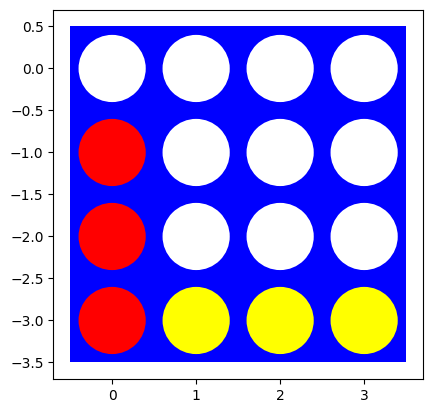

(1, 0)


In [ ]:
board1 = [[0, 0, 0, 0],
         [1, 0, 0, 0],
         [1, 0, 0, 0],
         [1, -1, -1, -1]]

visualize(board1)
move = smart_player(board1, PLAYER_1)
print(move)

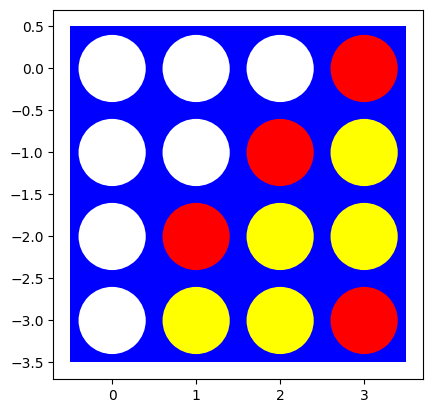

(1, 0)


In [ ]:
board2 = [[0, 0, 0, 1],
         [0, 0, 1, -1],
         [0, 1, -1, -1],
         [0, -1, -1, 1]]

visualize(board2)
move = smart_player(board2, PLAYER_1)
print(move)

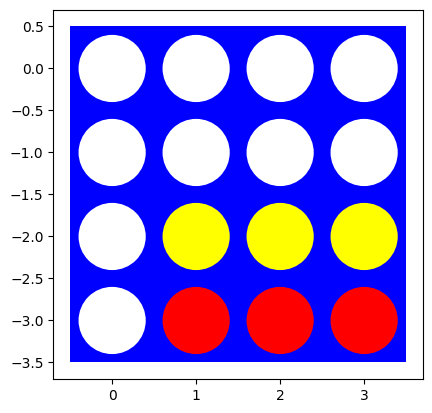

(1, 0)


In [ ]:
board3 = [[0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, -1, -1, -1],
         [0, 1, 1, 1]]

visualize(board3)
move = smart_player(board3, PLAYER_1)
print(move)

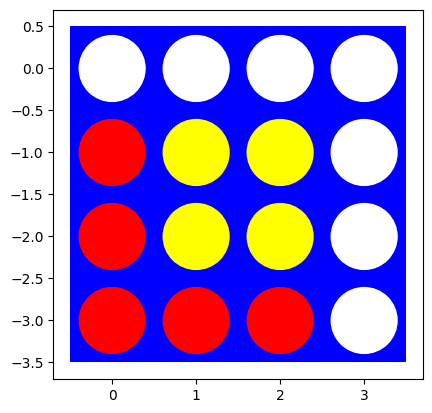

(1, 0)


In [ ]:
board4 = [[0, 0, 0, 0],
         [1, -1, -1, 0],
         [1, -1, -1, 0],
         [1, 1, 1, 0]]

visualize(board4)
move = smart_player(board4, PLAYER_1)
print(move)

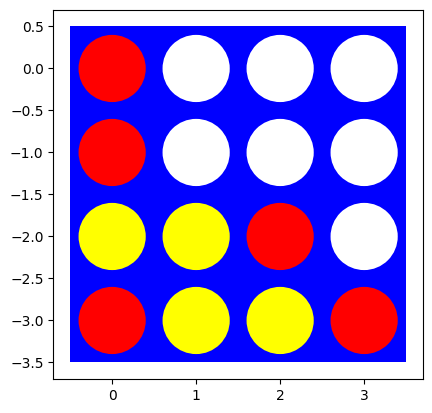

(1, 1)


In [ ]:
board5 = [[1, 0, 0, 0],
         [1, 0, 0, 0],
         [-1, -1, 1, 0],
         [1, -1, -1, 1]]

visualize(board5)
move = smart_player(board5, PLAYER_1)
print(move)

How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

TIMES FOR THE BOARDS

adding 1 column to the 4x4
- Number of nodes searched: 13482
CPU times: user 195 ms, sys: 435 µs, total: 195 ms
Wall time: 198 ms
(1, 0)

adding 2 column to the 4x4
- Number of nodes searched: 46843
CPU times: user 807 ms, sys: 0 ns, total: 807 ms
Wall time: 809 ms
(1, 0)

adding 3 column to the 4x4
- Number of nodes searched: 46843
CPU times: user 818 ms, sys: 1.64 ms, total: 820 ms
Wall time: 826 ms
(1, 0)




### Move ordering

Starting the search with better moves will increase the efficiency of alpha-beta pruning. Describe and implement a simple move ordering strategy. Make a table that shows how the ordering strategies influence the time it takes to make a move.

The implementation of a better move ordering is going for moves towards the center. These moves have a higher chance of more connection so in the move ordering we will order the list of actions in accordance of closest to the center, HERE is an Implementation

In [ ]:
# MOVE ORDERING ACTIONS
def heuristic(action, columns):
    # Simple heuristic: prefer actions closer to the center of the board
    return abs(action[1] - columns // 2)

def order_actions(board, player):
    global prev_mean
    possible_actions = []
    columns = len(board[0])
    for i in range(columns):
        if board[0][i] == 0:  # if the top of a column is empty, you can play there
            possible_actions.append((player, i))
        if not prev_mean and board[-1][i] == (player * -1):  # Check for "mean" move if applicable
            possible_actions.append((player * -1, i))

    # Sort actions based on heuristic
    ordered_actions = sorted(possible_actions, key=lambda action: heuristic(action, columns))
    return ordered_actions

def alpha_beta_search_order(board, player = PLAYER_1):
    global DEBUG, COUNT, prev_mean
    COUNT = 0
    original_prev_mean = prev_mean

    value, move = max_value_ab_order(board, player, -math.inf, +math.inf)

    if DEBUG >= 1: print(f"Number of nodes searched: {COUNT}")

    prev_mean = original_prev_mean
    return { "move": move, "value": value }

def max_value_ab_order(board, player, alpha, beta):
    global DEBUG, COUNT, prev_mean
    COUNT += 1
    original_prev_mean = prev_mean

    # return utility of state is a terminal state
    v = utility(board)
    if DEBUG >= 2: print(f"max: {board} [alpha,beta]=[{alpha},{beta}] v={v}")
    if v is not None:
        if DEBUG >= 2: print(f"     found terminal state. backtracking.")
        return v, None

    v, move = -math.inf, None

    # check all possible actions in the state, update alpha and return move with the largest value
    for a in order_actions(board, player):
        if a[0] == player * -1:
            prev_mean = True
        else:
            prev_mean = False

        new_board = result(board, player, a)
        v2, a2 = min_value_ab_order(new_board, (player * -1), alpha, beta)
        if DEBUG >= 2: print(f"max: {board} (backtracked) [alpha,beta]=[{alpha},{beta}] v={v2}")

        if v2 > v:
            v, move = v2, a
            alpha = max(alpha, v)
        if v >= beta:
            if DEBUG >= 2: print(f"     v>=beta ({v}>={beta}): pruning remaining subtree (actions). backtracking.")
            prev_mean = original_prev_mean
            return v, move

    prev_mean = original_prev_mean
    return v, move

def min_value_ab_order(board, player, alpha, beta):
    """opponent's best response."""
    global DEBUG, COUNT, prev_mean
    COUNT += 1
    original_prev_mean = prev_mean

    # return utility of state is a terminal state
    v = utility(board)
    if DEBUG >= 2: print(f"min: {board} [alpha,beta]=[{alpha},{beta}] v={v}")
    if v is not None:
        if DEBUG >= 2: print(f"     found terminal state. backtacking.")
        return v, None

    v, move = +math.inf, None

    # check all possible actions in the state, update beta and return move with the smallest value
    for a in order_actions(board, player):
        if a[0] == player * -1:
            prev_mean = True
        else:
            prev_mean = False

        new_board = result(board, player, a)
        v2, a2 = max_value_ab_order(new_board, (player * -1), alpha, beta)
        if DEBUG >= 2: print(f"min: {board} (backtracked) [alpha,beta]=[{alpha},{beta}] v={v2}")

        if v2 < v:
            v, move = v2, a
            beta = min(beta, v)
        if v <= alpha:
            if DEBUG >= 2: print(f"     v<=alpha ({v}<={alpha}): pruning remaining subtree (actions). backtracking.")
            prev_mean = original_prev_mean
            return v, move

    prev_mean = original_prev_mean
    return v, move


def smart_player_order(board, player = None):
    result = alpha_beta_search_order(board, player)
    return result['move']


In [ ]:
import time
board1 = [[0, 0, 0, 0],
         [1, 0, 0, 0],
         [1, 0, 0, 0],
         [1, -1, -1, -1]]

board2 = [[0, 0, 0, 1],
         [0, 0, 1, -1],
         [0, 1, -1, -1],
         [0, -1, -1, 1]]

board3 = [[0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, -1, -1, -1],
         [0, 1, 1, 1]]

def measure_execution_time(func, board, player):
    start_time = time.perf_counter()
    move = func(board, player)
    end_time = time.perf_counter()
    execution_time = end_time - start_time
    return execution_time, move

boards = [board1, board2, board3]
times_smart_player = []
times_smart_player_order = []

for i, board in enumerate(boards, start=1):
    exec_time, move = measure_execution_time(smart_player, board, PLAYER_1)
    exec_time_order, move_order = measure_execution_time(smart_player_order, board, PLAYER_1)

    times_smart_player.append(exec_time)
    times_smart_player_order.append(exec_time_order)


In [ ]:
board_cases = ["Board 1", "Board 2", "Board 3"]

# Create and display the table
import pandas as pd

# Creating a DataFrame
df = pd.DataFrame({
    "Board": board_cases,
    "Smart Player Time (s)": times_smart_player,
    "Smart Player with Order Time (s)": times_smart_player_order,
})

# Display the DataFrame
print(df)

     Board  Smart Player Time (s)  Smart Player with Order Time (s)
0  Board 1               0.132398                          1.501225
1  Board 2               0.024646                          0.077475
2  Board 3               0.007056                         13.860926


### The first few moves

Start with an empty board. This is the worst case scenario for minimax search with alpha-beta pruning since it needs solve all possible games that can be played (minus some pruning) before making the decision. What can you do?

For the first 3 moves we can set the algorithm to follow a specific connect 4 strategy to set up the rest of the game using conditionals. therefore it does not simulate the entire game in the beginning and just follow a specific strategy to set up a win.

### Playtime

Let the Minimax Search agent play a random agent on a small board. Analyze wins, losses and draws.

In [ ]:
def is_board_empty(board):
    for row in board:
        for cell in row:
            if cell != 0:
                return False  # Found a non-empty cell
    return True  # All cells are empty

# red is 1, PLAYER_1
# yellow is -1, PLAYER_2
def play_smart(p1, p2, N = 1000):
    global prev_mean
    score_board = {p1: 0, p2: 0, 0: 0} # count

    for i in range(N):  # 1000 time game
        game = empty_board((4,4))   # each game empty board
        prev_mean = False       # no prev mean
        player = PLAYER_1   #start with player 1 aka red

        while not terminal(game):
            if (player == PLAYER_1):
                if (is_board_empty(game)):
                    columns = len(board[0])
                    action = (player, columns // 2)
                else:
                    action = smart_player(game, player)  # player 1 is smart
            else:
                action = random_player(game, player)  # player 2 is random
            if action[0] == player * -1:
                prev_mean = True    # if it was a mean move then set to true
            else:
                prev_mean = False

            temp_board = result(game, player, action)
            game = temp_board

            player = player * -1 # switch player

        score = utility(game) # see if red, yellow or draw
        score_board[score] += 1

    return score_board

In [ ]:
results = play_smart(PLAYER_1, PLAYER_2)
print(results)

{1: 597, -1: 202, 0: 201}


The smart agent wins over the random agent, however there are still some draws in the match

## Task 4: Heuristic Alpha-Beta Tree Search [3 points]

### Heuristic evaluation function

Define and implement a heuristic evaluation function.

In [ ]:
# Your code/ answer goes here.
def evaluate_direction_horizontal(board, player):
  score = 0
  rowLen = len(board)
  colLen = len(board[0])

  # Check horizontal direction
  for row in range(rowLen):
    for col in range(colLen - 3):

      # Check consecutive discs in a horizontal line
      consecutive_count = 0

      # Check how many empty_spaces there are to place within a length 4 horizontal line
      empty_count = 0

      # Check to see how many disc is blocking the player from winning
      blocking_disc = 0

      for i in range(4):
          # Check if the space to the right has the player's disc
          if board[row][col + i] == player:
              consecutive_count += 1

          # Check if the space to the right is empty
          elif board[row][col + i] == 0:
              empty_count += 1

          # Check if the space to the right has the opponent's disc
          elif board[row][col + i] != player:
              blocking_disc += 1

      if consecutive_count == 4:
        score = 10000
        break
      else:
        score += consecutive_count * 1000 + empty_count * 500 + blocking_disc * -1000

  return score

def evaluate_direction_vertical(board, player):
  score = 0
  rowLen = len(board)
  colLen = len(board[0])

  # Check vertical direction
  for col in range(colLen):
    for row in range(rowLen - 3):
        # Check consecutive discs in a horizontal line
        consecutive_count = 0

        # Check how many empty_spaces there are to place within a length 4 horizontal line
        empty_count = 0

        # Check to see how many disc is blocking the player from winning
        blocking_disc = 0

        for i in range(4):
          # Check if the space on top has the player's disc
          if board[row + i][col] == player:
              consecutive_count += 1
          # Check if the space on top is empty
          elif board[row + i][col] == 0:
              empty_count += 1
          # Check if the space on top has the opponent's disc
          elif board[row + i][col] != player:
              blocking_disc += 1

        if consecutive_count == 4:
          score = 10000
          break
        else:
          score += consecutive_count * 1000 + empty_count * 500 + blocking_disc * -1000

  return score

# Check ascending diagonal
def evaluate_direction_ascending_diagonal(board, player):
  score = 0
  rowLen = len(board)
  colLen = len(board[0])

  for row in range(rowLen - 3):
    for col in range(colLen - 3):
        # Check consecutive discs in a horizontal line
        consecutive_count = 0

        # Check how many empty_spaces there are to place within a length 4 horizontal line
        empty_count = 0

        # Check to see how many disc is blocking the player from winning
        blocking_disc = 0

        for i in range(4):
          # Check if the the upper right space has the player's disc
          if board[row + i][col + i] == player:
            consecutive_count += 1
          # Check if the the upper right space is empty
          elif board[row + i][col + i] == 0:
            empty_count += 1
          # Check if the the upper right space has the opponent's disc
          elif board[row + i][col + i] != player:
            blocking_disc += 1

    if consecutive_count == 4:
      score = 10000
      break
    else:
      score += consecutive_count * 1000 + empty_count * 500 + blocking_disc * -1000

  return score

def evaluate_direction_descending_diagonal(board, player):
  # Check descending diagonal
  score = 0
  rowLen = len(board)
  colLen = len(board[0])

  for row in range(3, rowLen):
    for col in range(colLen - 3):
      # Check consecutive discs in a horizontal line
      consecutive_count = 0

      # Check how many empty_spaces there are to place within a length 4 horizontal line
      empty_count = 0

      # Check to see how many disc is blocking the player from winning
      blocking_disc = 0

      for i in range(4):
        if board[row - i][col + i] == player:
          consecutive_count += 1
        elif board[row - i][col + i] == 0:
          empty_count += 1
        elif board[row - i][col + i] != player:
          blocking_disc += 1

      if consecutive_count == 4:
        score = 10000
        break
      else:
        score += consecutive_count * 1000 + empty_count * 500 + blocking_disc * -100

  return score

# Make it so that the score is within the boundaries of -1 and 1
def normalize_score(score):
    return max(-1, min(1, score / 10000))

def heuristic_evaluation(board, player):
    score = 0
    first_score = evaluate_direction_vertical(board, player)
    if (first_score == 10000):
      return normalize_score(first_score)

    second_score = evaluate_direction_horizontal(board, player)
    if (second_score == 10000):
      return normalize_score(second_score)

    third_score = evaluate_direction_ascending_diagonal(board, player)
    if (third_score == 10000):
      return normalize_score(third_score)

    fourth_score = evaluate_direction_descending_diagonal(board, player)
    if (fourth_score == 10000):
      return normalize_score(fourth_score)

    return normalize_score(first_score + second_score + third_score + fourth_score)



### Cutting off search

Modify your Minimax Search with Alpha-Beta Pruning to cut off search at a specified depth and use the heuristic evaluation function. Experiment with different cutoff values.

In [ ]:
# Your code/ answer goes here.
import math
# global variables
DEBUG = 1 # 1 ... count nodes, 2 ... debug each node
COUNT = 0

def cutting_off_search(board, limited_depth, player = PLAYER_1):
    global DEBUG, COUNT, prev_mean
    COUNT = 0
    original_prev_mean = prev_mean

    value, move = max_value_ab_h(board, player, -math.inf, +math.inf, 0, limited_depth)

    if DEBUG >= 1: print(f"Number of nodes searched: {COUNT}")

    prev_mean = original_prev_mean
    return { "move": move, "value": value }

def max_value_ab_h(board, player, alpha, beta, depth, limited_depth):
    global DEBUG, COUNT, prev_mean
    COUNT += 1
    original_prev_mean = prev_mean

    # return utility of state is a terminal state
    v = terminal(board)
    if DEBUG >= 2: print(f"max: {board} [alpha,beta]=[{alpha},{beta}] v={v}")
    if v is not None and depth >= limited_depth:
        if DEBUG >= 2: print(f"     found terminal state. backtracking.")
        return heuristic_evaluation(board, player), None

    v, move = -math.inf, None

    # check all possible actions in the state, update alpha and return move with the largest value
    for a in actions(board, player):
        if a[0] == player * -1:
            prev_mean = True
        else:
            prev_mean = False

        new_board = result(board, player, a)
        v2, a2 = min_value_ab_h(new_board, (player * -1), alpha, beta, depth + 1, limited_depth)
        if DEBUG >= 2: print(f"max: {board} (backtracked) [alpha,beta]=[{alpha},{beta}] v={v2}")

        if v2 > v:
            v, move = v2, a
            alpha = max(alpha, v)
        if v >= beta:
            if DEBUG >= 2: print(f"     v>=beta ({v}>={beta}): pruning remaining subtree (actions). backtracking.")
            prev_mean = original_prev_mean
            return v, move

    prev_mean = original_prev_mean
    return v, move

def min_value_ab_h(board, player, alpha, beta, depth, limited_depth):
    """opponent's best response."""
    global DEBUG, COUNT, prev_mean
    COUNT += 1
    original_prev_mean = prev_mean

    # return utility of state is a terminal state
    v = terminal(board)
    if DEBUG >= 2: print(f"min: {board} [alpha,beta]=[{alpha},{beta}] v={v}")
    if v is not None and depth >= limited_depth:
        if DEBUG >= 2: print(f"     found terminal state. backtacking.")
        return heuristic_evaluation(board, player), None

    v, move = +math.inf, None

    # check all possible actions in the state, update beta and return move with the smallest value
    for a in actions(board, player):
        if a[0] == player * -1:
            prev_mean = True
        else:
            prev_mean = False

        new_board = result(board, player, a)
        v2, a2 = max_value_ab_h(new_board, (player * -1), alpha, beta, depth + 1, limited_depth)
        if DEBUG >= 2: print(f"min: {board} (backtracked) [alpha,beta]=[{alpha},{beta}] v={v2}")

        if v2 < v:
            v, move = v2, a
            beta = min(beta, v)
        if v <= alpha:
            if DEBUG >= 2: print(f"     v<=alpha ({v}<={alpha}): pruning remaining subtree (actions). backtracking.")
            prev_mean = original_prev_mean
            return v, move

    prev_mean = original_prev_mean
    return v, move


def smart_player_h(board, depth, player = None):
    result = cutting_off_search(board, depth, player)
    return result['move']

Experiment with the same manually created boards as above to check if the agent spots winning opportunities.

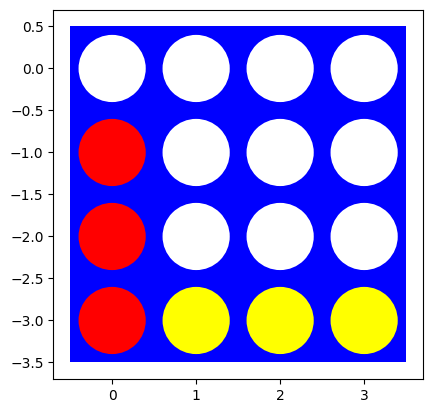

Number of nodes searched: 114


(1, 0)

In [ ]:
# Your code/ answer goes here.
board1 = [[0, 0, 0, 0],
         [1, 0, 0, 0],
         [1, 0, 0, 0],
         [1, -1, -1, -1]]

visualize(board1)
smart_player_h(board1, 4, PLAYER_1)

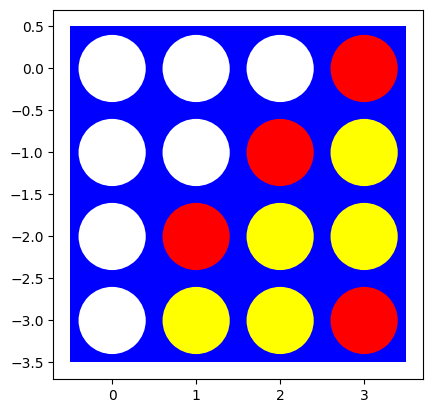

Number of nodes searched: 100


(1, 0)

In [ ]:
board2 = [[0, 0, 0, 1],
         [0, 0, 1, -1],
         [0, 1, -1, -1],
         [0, -1, -1, 1]]

visualize(board2)
smart_player_h(board2, 4, PLAYER_1)

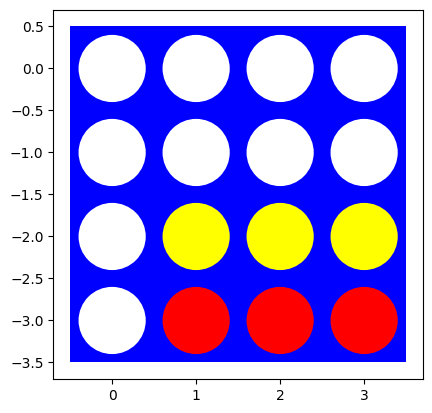

Number of nodes searched: 162


(1, 0)

In [ ]:
board3 = [[0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, -1, -1, -1],
         [0, 1, 1, 1]]


visualize(board3)
smart_player_h(board3, 4, PLAYER_1)


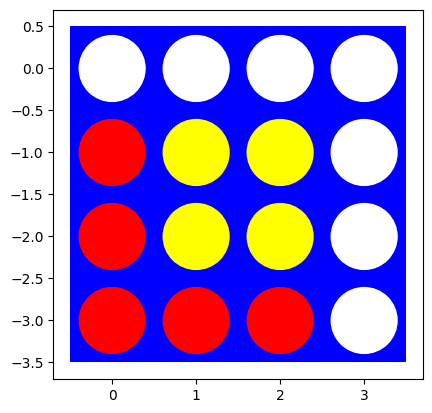

Number of nodes searched: 64


(1, 0)

In [ ]:
board4 = [[0, 0, 0, 0],
         [1, -1, -1, 0],
         [1, -1, -1, 0],
         [1, 1, 1, 0]]


visualize(board4)
smart_player_h(board4, 4, PLAYER_1)

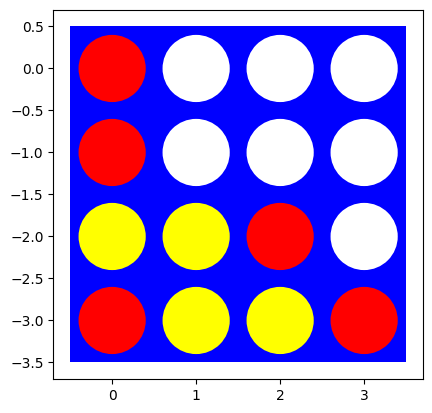

Number of nodes searched: 76


(1, 1)

In [ ]:
board5 = [[1, 0, 0, 0],
         [1, 0, 0, 0],
         [-1, -1, 1, 0],
         [1, -1, -1, 1]]


visualize(board5)
smart_player_h(board5, 4, PLAYER_1)


How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

# Board 1 4x4
Number of nodes searched: 114
CPU times: user 5.89 ms, sys: 0 ns, total: 5.89 ms
Wall time: 5.97 ms

# Board 1 4x5
Number of nodes searched: 155
CPU times: user 5.44 ms, sys: 0 ns, total: 5.44 ms
Wall time: 5.3 ms

# Board 1 4x6
Number of nodes searched: 148
CPU times: user 7.83 ms, sys: 0 ns, total: 7.83 ms
Wall time: 8.16 ms

# Board 1 4x7
Number of nodes searched: 255
CPU times: user 13.6 ms, sys: 0 ns, total: 13.6 ms
Wall time: 13.8 ms


### Playtime

Let two heuristic search agents (different cutoff depth, different heuristic evaluation function) compete against each other on a reasonably sized board. Since there is no randomness, you only need to let them play once.

In [ ]:
# Your code/ answer goes here.
def evaluate_direction(board, player, vertical_direction, horizontal_direction):
  score = 0
  rowLen = len(board)
  colLen = len(board[0])

  # Check horizontal direction
  if (vertical_direction == 0 and horizontal_direction == 1):
    for row in range(rowLen):
      for col in range(colLen - 3):
        count = 0
        for i in range(4):
            # Check if the space to the right has the player's disc
            if board[row][col + i] == player:
                score += 10
                count += 1
            # Check if the space to the right is empty
            elif board[row][col + i] == 0:
                score += 5
            # Check if the space to the right has the opponent's disc
            elif board[row][col + i] != player:
                score -= 10
        if count == 4:
          break

  # Check vertical direction
  elif (vertical_direction == 1 and horizontal_direction == 0):
    for col in range(colLen):
        for row in range(rowLen - 3):
          count = 0
          for i in range(4):
            # Check if the space on top has the player's disc
            if board[row + i][col] == player:
                score += 10
                count += 1
            # Check if the space on top is empty
            elif board[row + i][col] == 0:
                score += 5
            # Check if the space on top has the opponent's disc
            elif board[row + i][col] != player:
                score -= 10
          if count == 4:
            break

  # Check ascending diagonal
  elif (vertical_direction == 1 and horizontal_direction == 1):
    for row in range(rowLen - 3):
      for col in range(colLen - 3):
        count = 0
        for i in range(4):
          # Check if the the upper right space has the player's disc
          if board[row + i][col + i] == player:
            score += 10
            count += 1
          # Check if the the upper right space is empty
          elif board[row + i][col + i] == 0:
            score += 5
          # Check if the the upper right space has the opponent's disc
          elif board[row + i][col + i] != player:
            score -= 10
        if count == 4:
          break


  # Check descending diagonal
  elif (vertical_direction == -1 and horizontal_direction == 1):
    for row in range(3, rowLen):
      for col in range(colLen - 3):
        count = 0
        for i in range(4):
          if board[row - i][col + i] == player:
            score += 10
            count += 1
          elif board[row - i][col + i] == 0:
            score += 5
          elif board[row - i][col + i] != player:
            score -= 10
        if count == 4:
          break

  if (count == 4):
    return 10000

  return score

def heuristic_evaluation(board, player):
    score = 0
    first_score = evaluate_direction(board, player, 0, 1)
    if (first_score == 10000):
      return first_score

    second_score = evaluate_direction(board, player, 1, 0)
    if (second_score == 10000):
      return second_score

    third_score = evaluate_direction(board, player, 1, 1)
    if (third_score == 10000):
      return third_score


    fourth_score = evaluate_direction(board, player, -1, 1)
    if (fourth_score == 10000):
      return fourth_score

    return (first_score + second_score + third_score + fourth_score) / 100

In [ ]:
# Your code/ answer goes here.
import math
# global variables
DEBUG = 1 # 1 ... count nodes, 2 ... debug each node
COUNT = 0

def cutting_off_search(board, limited_depth, player = PLAYER_1):
    global DEBUG, COUNT, prev_mean
    COUNT = 0
    original_prev_mean = prev_mean

    value, move = max_value_ab_h(board, player, -math.inf, +math.inf, 0, limited_depth)

    if DEBUG >= 1: print(f"Number of nodes searched: {COUNT}")

    prev_mean = original_prev_mean
    return { "move": move, "value": value }

def max_value_ab_h_two(board, player, alpha, beta, depth, limited_depth):
    global DEBUG, COUNT, prev_mean
    COUNT += 1
    original_prev_mean = prev_mean

    # return utility of state is a terminal state
    v = terminal(board)
    if DEBUG >= 2: print(f"max: {board} [alpha,beta]=[{alpha},{beta}] v={v}")
    if v is not None and depth >= limited_depth:
        if DEBUG >= 2: print(f"     found terminal state. backtracking.")
        return heuristic_evaluation_two(board, player), None

    v, move = -math.inf, None

    # check all possible actions in the state, update alpha and return move with the largest value
    for a in actions(board, player):
        if a[0] == player * -1:
            prev_mean = True
        else:
            prev_mean = False

        new_board = result(board, player, a)
        v2, a2 = min_value_ab_h_two(new_board, (player * -1), alpha, beta, depth + 1, limited_depth)
        if DEBUG >= 2: print(f"max: {board} (backtracked) [alpha,beta]=[{alpha},{beta}] v={v2}")

        if v2 > v:
            v, move = v2, a
            alpha = max(alpha, v)
        if v >= beta:
            if DEBUG >= 2: print(f"     v>=beta ({v}>={beta}): pruning remaining subtree (actions). backtracking.")
            prev_mean = original_prev_mean
            return v, move

    prev_mean = original_prev_mean
    return v, move

def min_value_ab_h_two(board, player, alpha, beta, depth, limited_depth):
    """opponent's best response."""
    global DEBUG, COUNT, prev_mean
    COUNT += 1
    original_prev_mean = prev_mean

    # return utility of state is a terminal state
    v = terminal(board)
    if DEBUG >= 2: print(f"min: {board} [alpha,beta]=[{alpha},{beta}] v={v}")
    if v is not None and depth >= limited_depth:
        if DEBUG >= 2: print(f"     found terminal state. backtacking.")
        return heuristic_evaluation_two(board, player), None

    v, move = +math.inf, None

    # check all possible actions in the state, update beta and return move with the smallest value
    for a in actions(board, player):
        if a[0] == player * -1:
            prev_mean = True
        else:
            prev_mean = False

        new_board = result(board, player, a)
        v2, a2 = max_value_ab_h_two(new_board, (player * -1), alpha, beta, depth + 1, limited_depth)
        if DEBUG >= 2: print(f"min: {board} (backtracked) [alpha,beta]=[{alpha},{beta}] v={v2}")

        if v2 < v:
            v, move = v2, a
            beta = min(beta, v)
        if v <= alpha:
            if DEBUG >= 2: print(f"     v<=alpha ({v}<={alpha}): pruning remaining subtree (actions). backtracking.")
            prev_mean = original_prev_mean
            return v, move

    prev_mean = original_prev_mean
    return v, move


def smart_player_h_second(board, depth, player = None):
    result = cutting_off_search(board, depth, player)
    return result['move']

Number of nodes searched: 29382
(1, 3)


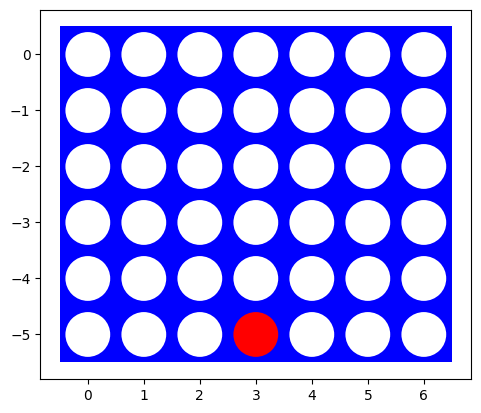

Number of nodes searched: 1842
(-1, 3)


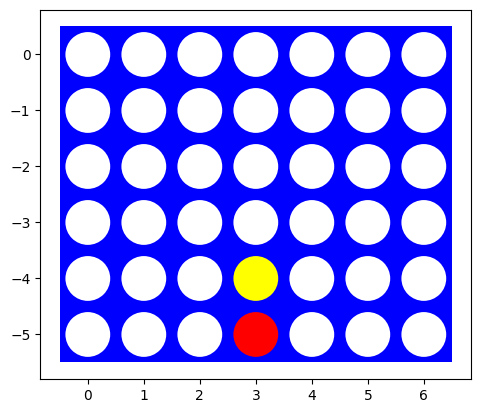

Number of nodes searched: 30149
(1, 2)


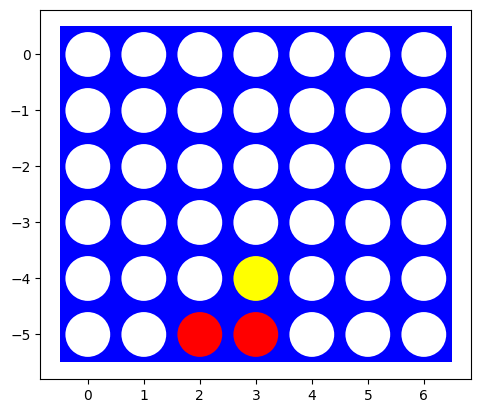

Number of nodes searched: 1697
(-1, 3)


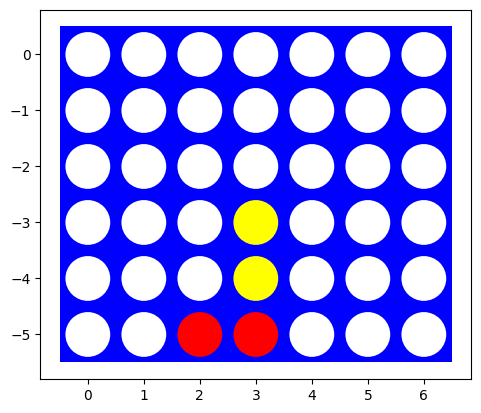

Number of nodes searched: 30043
(1, 3)


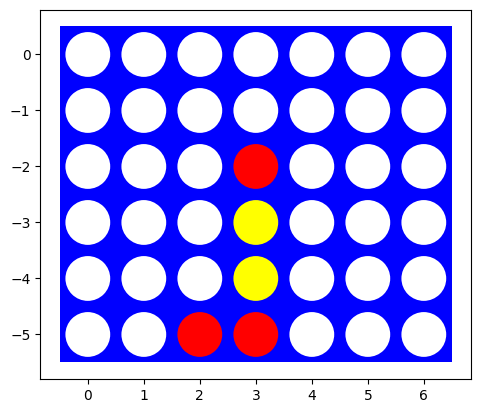

Number of nodes searched: 1396
(-1, 3)


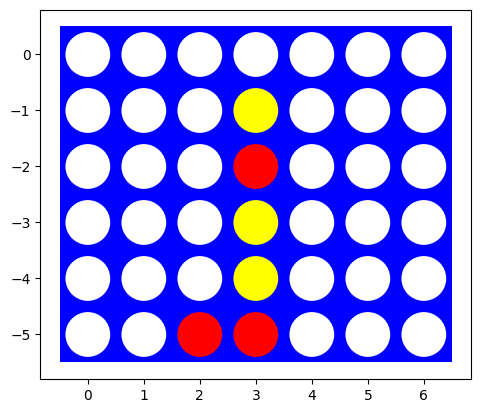

Number of nodes searched: 22601
(1, 1)


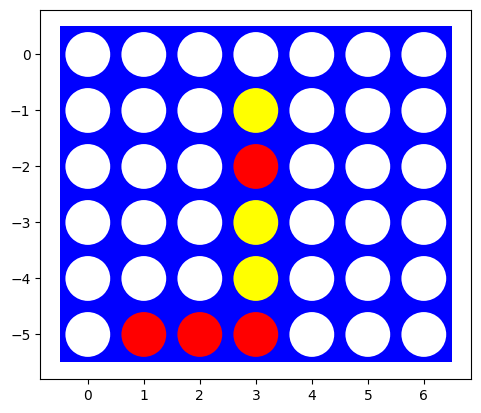

Number of nodes searched: 1390
(-1, 2)


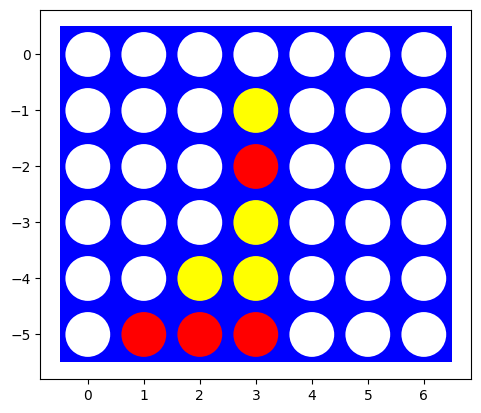

Number of nodes searched: 23728
(1, 3)


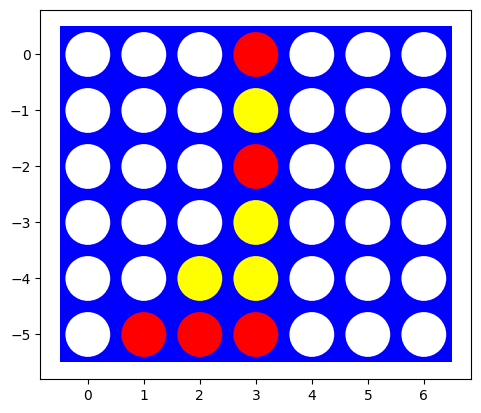

Number of nodes searched: 809
(-1, 2)


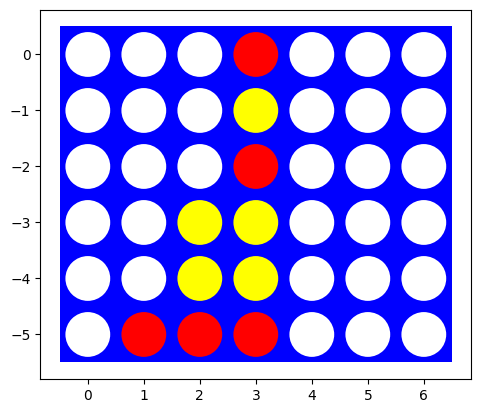

Number of nodes searched: 12669
(1, 2)


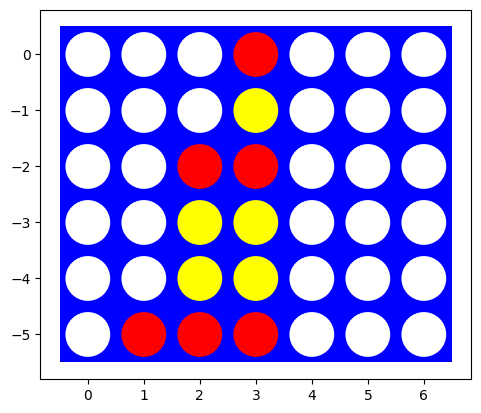

Number of nodes searched: 662
(-1, 2)


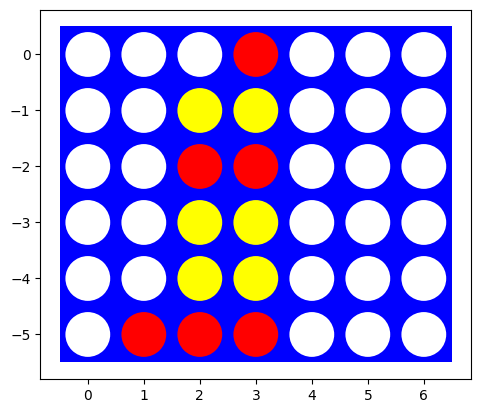

Number of nodes searched: 8015
(1, 1)


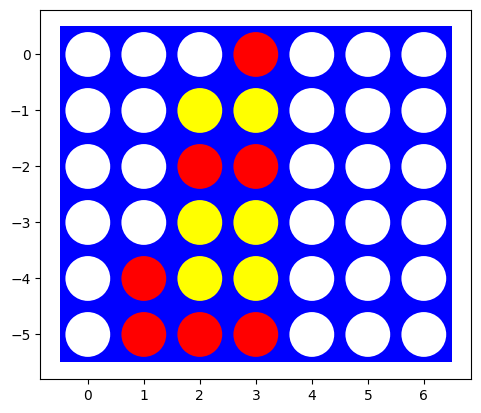

Number of nodes searched: 567
(-1, 1)


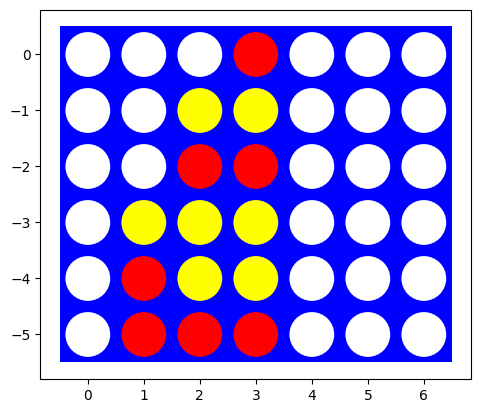

Number of nodes searched: 7469
(1, 1)


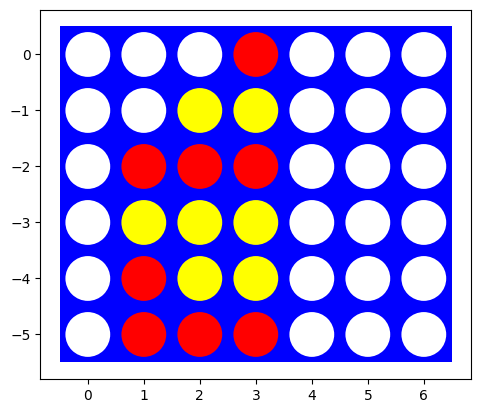

Number of nodes searched: 871
(-1, 1)


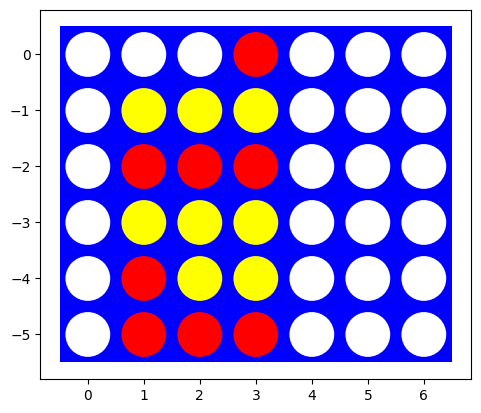

Number of nodes searched: 9832
(1, 2)


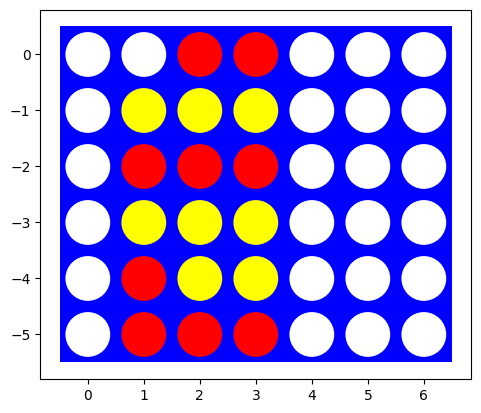

Number of nodes searched: 452
(-1, 4)


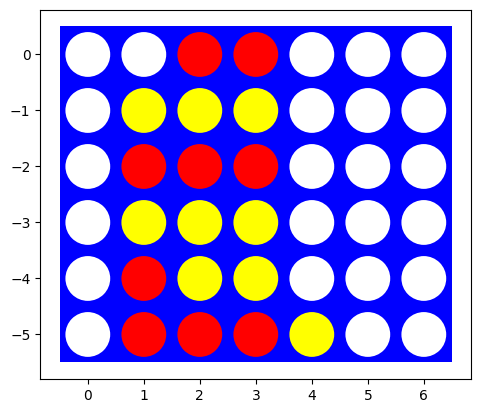

Number of nodes searched: 6668
(1, 0)


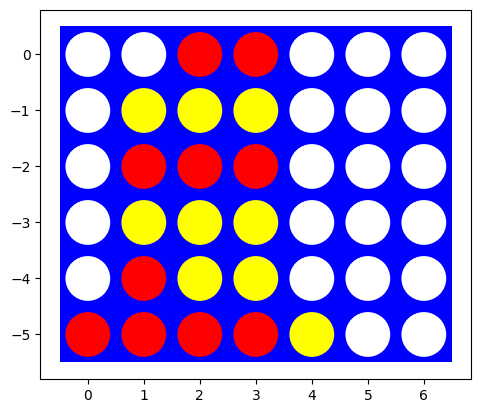

{1: 1, -1: 0, 0: 0}

In [ ]:
# red is 1, PLAYER_1
# yellow is -1, PLAYER_2
def play_smart_h(p1, p2, N = 1):
    global prev_mean
    score_board = {1: 0, -1: 0, 0: 0} # count

    game = [[0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0]]   # each game empty board

    prev_mean = False       # no prev mean
    player = PLAYER_1   #start with player 1 aka red

    while not terminal(game):
        if (player == PLAYER_1):
            action = p1(game, 6, player)
        else:
            action = p2(game, 4, player)
        if action[0] == player * -1:
            prev_mean = True    # if it was a mean move then set to true
        else:
            prev_mean = False

        temp_board = result(game, player, action)
        game = temp_board
        print(action)
        visualize(temp_board)
        if terminal(game): # if at a end game point
            score = utility(game) # see if red, yellow or draw
            score_board[score] += 1
            break

        player = player * -1 # switch player

    return score_board

play_smart_h(smart_player_h, smart_player_h_second)


---
Assignment adapted from [Michael Hahsler](https://github.com/mhahsler/CS7320-AI) under [CC BY-SA](https://creativecommons.org/licenses/by-sa/4.0/deed.en) license.


In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test

In [ ]:
test